In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',5000)
import os
from glob import iglob

In [11]:
# Load all structural p-values across both analyses
df = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-05-27/exac/daf_K_summary.txt",delimiter='\t')
df = df.drop_duplicates(["structid","chain"])

In [12]:
print "Number of structures evaluated:"
print len(df)
print "Number of variants evluated:"
print "%.0f"%np.sum(df["N"])

from qvalue import estimate
THRESH = 0.1

df.ix[~df[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(df.ix[~df[ "Kp"].isnull(), "Kp"].values)
df.ix[~df["wKp"].isnull(),"wKq"],wK_lam,wK_pi = estimate(df.ix[~df["wKp"].isnull(),"wKp"].values)

print "\nProteins passing an FDR of %.0f%% for the unweighted analysis"%(THRESH*100)
print "Significant:   %4d"%( df['Kq']<THRESH).sum()
print "    Clustered: %4d"%((df['Kq']<THRESH) & (df["Kz"]>0)).sum()
print "    Dispersed: %4d"%((df['Kq']<THRESH) & (df["Kz"]<0)).sum()

print "\nProteins passing an FDR of %.0f%% for the weighted analysis"%(THRESH*100)
print "Significant:   %4d"%(df["wKq"]<THRESH).sum()
print "    Clustered: %4d"%((df["wKq"]<THRESH) & (df.ix[~df["wKp"].isnull(),"wKz"]>0)).sum()
print "    Dispersed: %4d"%((df["wKq"]<THRESH) & (df.ix[~df["wKp"].isnull(),"wKz"]<0)).sum()

Number of structures evaluated:
4509
Number of variants evluated:
196176

Proteins passing an FDR of 10% for the unweighted analysis
Significant:     44
    Clustered:   16
    Dispersed:   28

Proteins passing an FDR of 10% for the weighted analysis
Significant:      0
    Clustered:    0
    Dispersed:    0


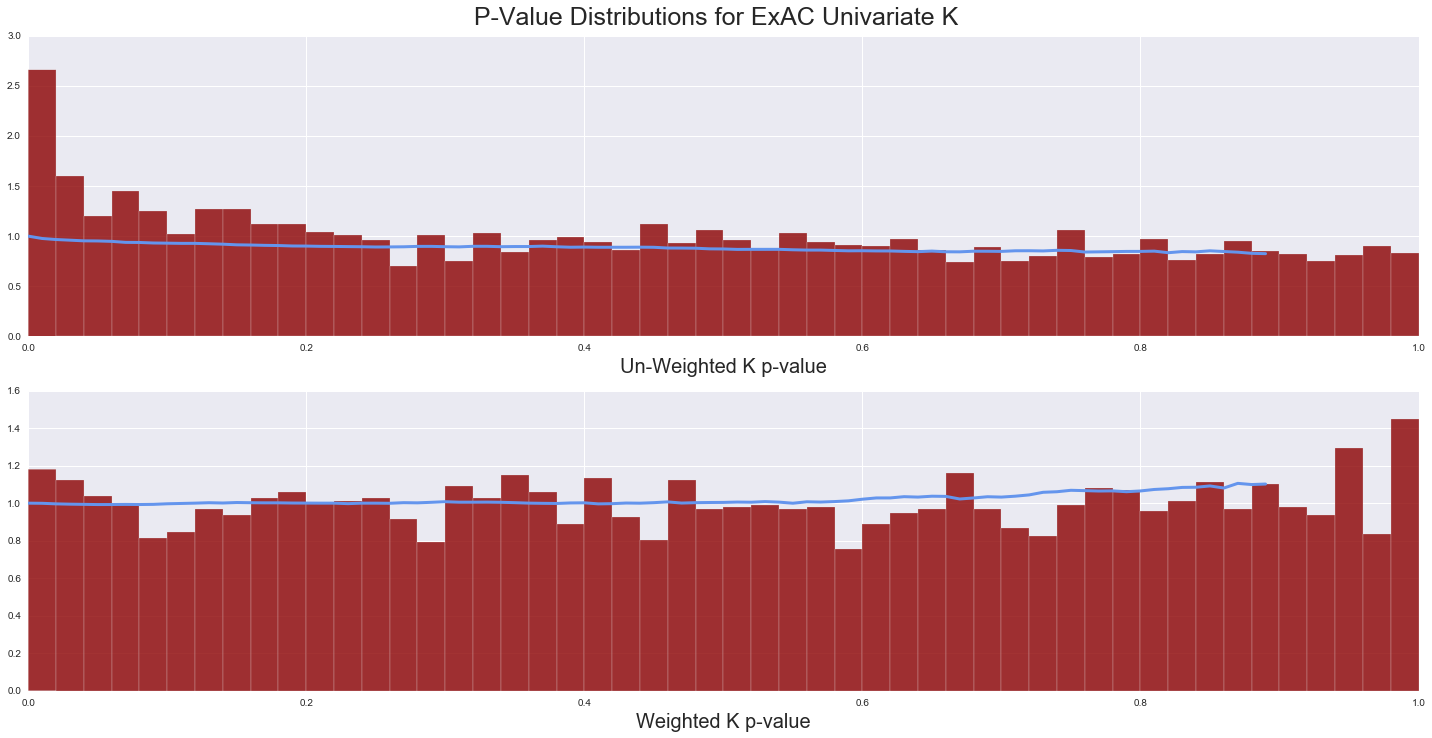

In [13]:
# P-Value Distributions
fig,ax = plt.subplots(2,1,figsize=(20,10))
plt.suptitle("P-Value Distributions for ExAC Univariate K",fontsize=25,y=1.02)
ax[0].set_xlabel("Un-Weighted K p-value",fontsize=20)
# ax[0].hist(df["Kzp"],bins=np.arange(0,1.02,0.02),color="darkblue",normed=True)
ax[0].hist(df["Kp"],bins=np.arange(0,1.02,0.02),color="darkred",alpha=0.8,normed=True)
ax[0].plot(K_lam,K_pi,lw=3,c='cornflowerblue')
ax[1].set_xlabel("Weighted K p-value",fontsize=20)
# ax[1].hist(df["wKzp"],bins=np.arange(0,1.02,0.02),color="darkblue",normed=True)
ax[1].hist(df["wKp"],bins=np.arange(0,1.02,0.02),color="darkred",alpha=0.8,normed=True)
ax[1].plot(wK_lam,wK_pi,lw=3,c='cornflowerblue')
plt.tight_layout()
plt.show()

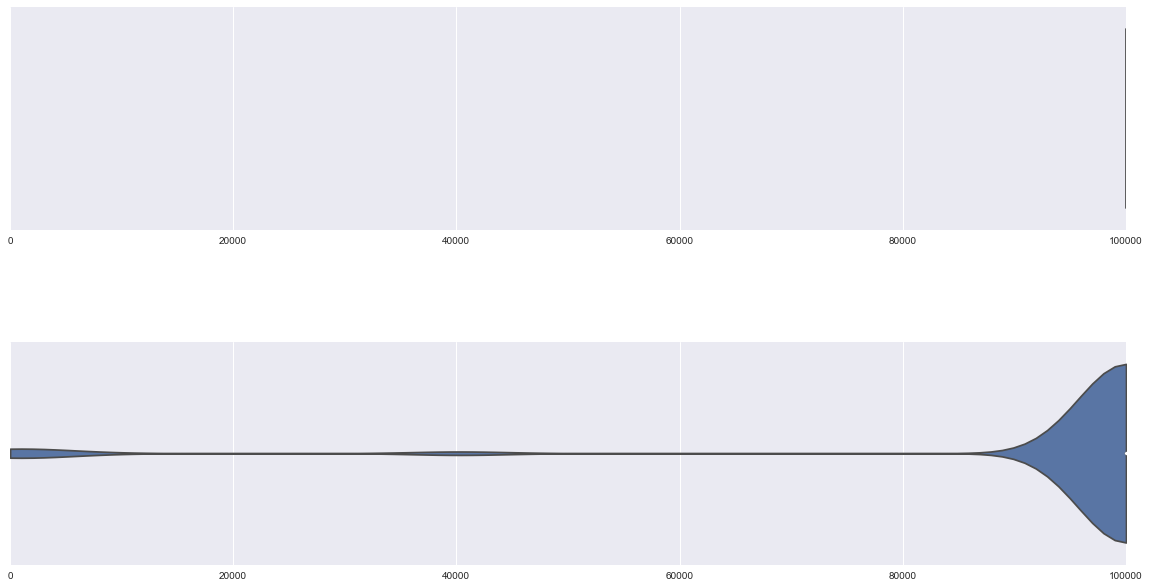

In [14]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
sns.violinplot(df['P'].values, cut=0,ax=ax[0])
sns.violinplot(df['wP'].values,cut=0,ax=ax[1])
ax[0].set_xlim([0,100000])
ax[1].set_xlim([0,100000])
plt.show()

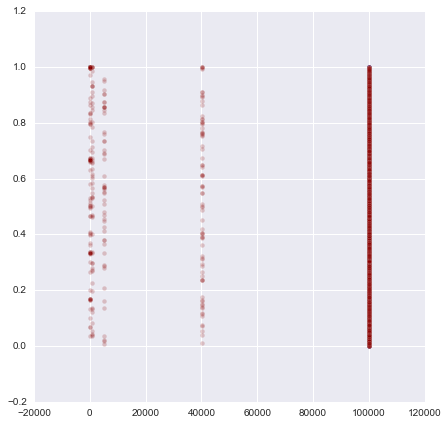

In [15]:
plt.figure(figsize=(7,7))
plt.scatter(df["P"],df["Kp"],c="mediumblue",alpha=0.2)
plt.scatter(df["wP"],df["wKp"],c="darkred",alpha=0.2)

Fully permuted:      4174
Partially permuted:   335
Proportion of p=1.0 w/ <100k permutations: 0.98
Proteins w/ wKp=1.0:   46


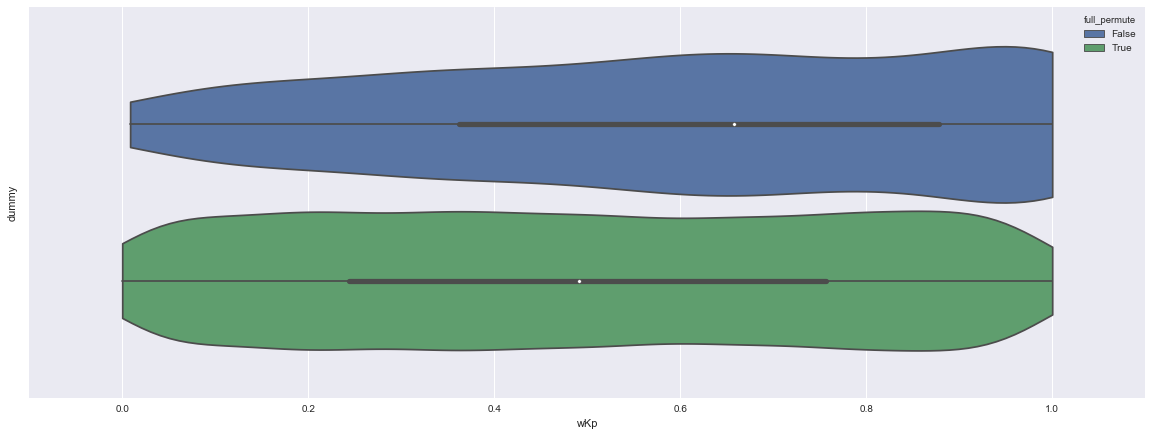

In [16]:
tdf = df.copy()
tdf["full_permute"] = tdf["wP"]==99999
print "Fully permuted:      %4d"%tdf["full_permute"].sum()
print "Partially permuted:  %4d"%(len(tdf)-tdf["full_permute"].sum())
print "Proportion of p=1.0 w/ <100k permutations: %.2f"%(((tdf["wKp"]==1.0) & ~(tdf["full_permute"])).sum() / float((tdf["wKp"]==1.0).sum()))
print "Proteins w/ wKp=1.0: %4d"%(tdf["wKp"]==1.0).sum()
tdf['dummy'] = ''
plt.figure(figsize=(20,7))
sns.violinplot(x='wKp',y='dummy',hue='full_permute',data=tdf,cut=0)
plt.xlim([-0.1,1.1])
plt.show()

In [17]:
dfu = pd.DataFrame(df[["Kp","Kz"]].values,columns=["p","z"])
dfu['q'] = estimate(dfu["p"].values)[0]
dfu["w"] = "un-weighted"
dfw = pd.DataFrame(df[["wKp","wKz"]].values,columns=["p","z"])
dfw['w'] = "weighted"
dfw.ix[~dfw['p'].isnull(),'q'] = estimate(dfw.ix[~dfw['p'].isnull(),"p"].values)[0]
dfv = pd.concat((dfu,dfw))
dfv['dummy'] = ""

fig,ax = plt.subplots(1,3,figsize=(20,10),sharey=True)
sns.violinplot(x='dummy',y="z",hue='w',data=dfv,ax=ax[0],cut=1,orient='v',split=True,inner='quart')
dfv1 = dfv[dfv["p"]<0.05]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=True,jitter=True,lw=0.5)
dfv1 = dfv[dfv["q"]<THRESH]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=True,jitter=True,lw=0.5)
ax[0].set_xlabel("ALL",fontsize=15)
ax[1].set_xlabel("Nominally Significant (p<0.05)",fontsize=15)
ax[2].set_xlabel("FDR Significant (q<%.2f)"%THRESH,fontsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
plt.ylim([-5,15])
ax[0].axhline(0.,ls='dashed',c='black')
ax[1].axhline(0.,ls='dashed',c='black')
ax[2].axhline(0.,ls='dashed',c='black')
plt.show()

AssertionError: p-values should be between 0 and 1

In [ ]:
print "Un-Weighted: FDR-Significant Proteins"
print df.ix[df["Kq"]<0.1,["structid","chain","Kz","Kp","Kq"]]

print "\nWeighted: FDR-Significant Proteins"
print df.ix[df["wKq"]<0.1,["structid","chain","wKz","wKp","wKq"]]

In [ ]:
print df.columns

In [ ]:
plt.figure(figsize=(20,7))
sns.violinplot(df["T"],bins=100)
plt.show()

In [ ]:
plt.figure(figsize=(20,7))
sns.violinplot(df.ix[df["Kq"]<0.1,"T"],bins=100)
plt.show()

In [ ]:
# Generate a list of significant structures for overlap with ClinVar (see the end of the univariate ClinVar notebook)
sig = list(df.ix[(df['Kq']<0.1) & (df['Kz']>0),'structid'].values)
sig.extend(df.ix[(df['wKq']<0.1) & (df['wKz']>0),'structid'].values)
print list(set(sig))

In [ ]:
# SigClust
print df.ix[((df["Kq"]<0.1) & (df["Kz"]>0)) | ((df["wKq"]<0.1) & df["wKq"]>0),["structid","chain"]]

In [ ]:
# SigDisp
print df.ix[((df["Kq"]<0.1) & (df["Kz"]<0)) | ((df["wKq"]<0.1) & df["wKq"]<0),["structid","chain"]]

In [ ]:
# NonSig
print df.ix[(df["Kq"]>0.1) & (df["wKq"]>0.1),["structid","chain"]]